# Building Energy Efficiency Prediction
This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters.

#### Data Exploration

In [1]:
import numpy as np
import torch
import os
from os import path
from sklearn.model_selection import KFold
import pandas as pd
import zipfile
import urllib.request


if not path.exists("UCI"): 
    os.mkdir("UCI")

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
file_name = url.split('/')[-1]
if not path.exists("UCI/" + file_name):
    urllib.request.urlretrieve(url, "UCI/" + file_name)

ds = pd.read_excel('UCI/ENB2012_data.xlsx', header=0)
ds.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


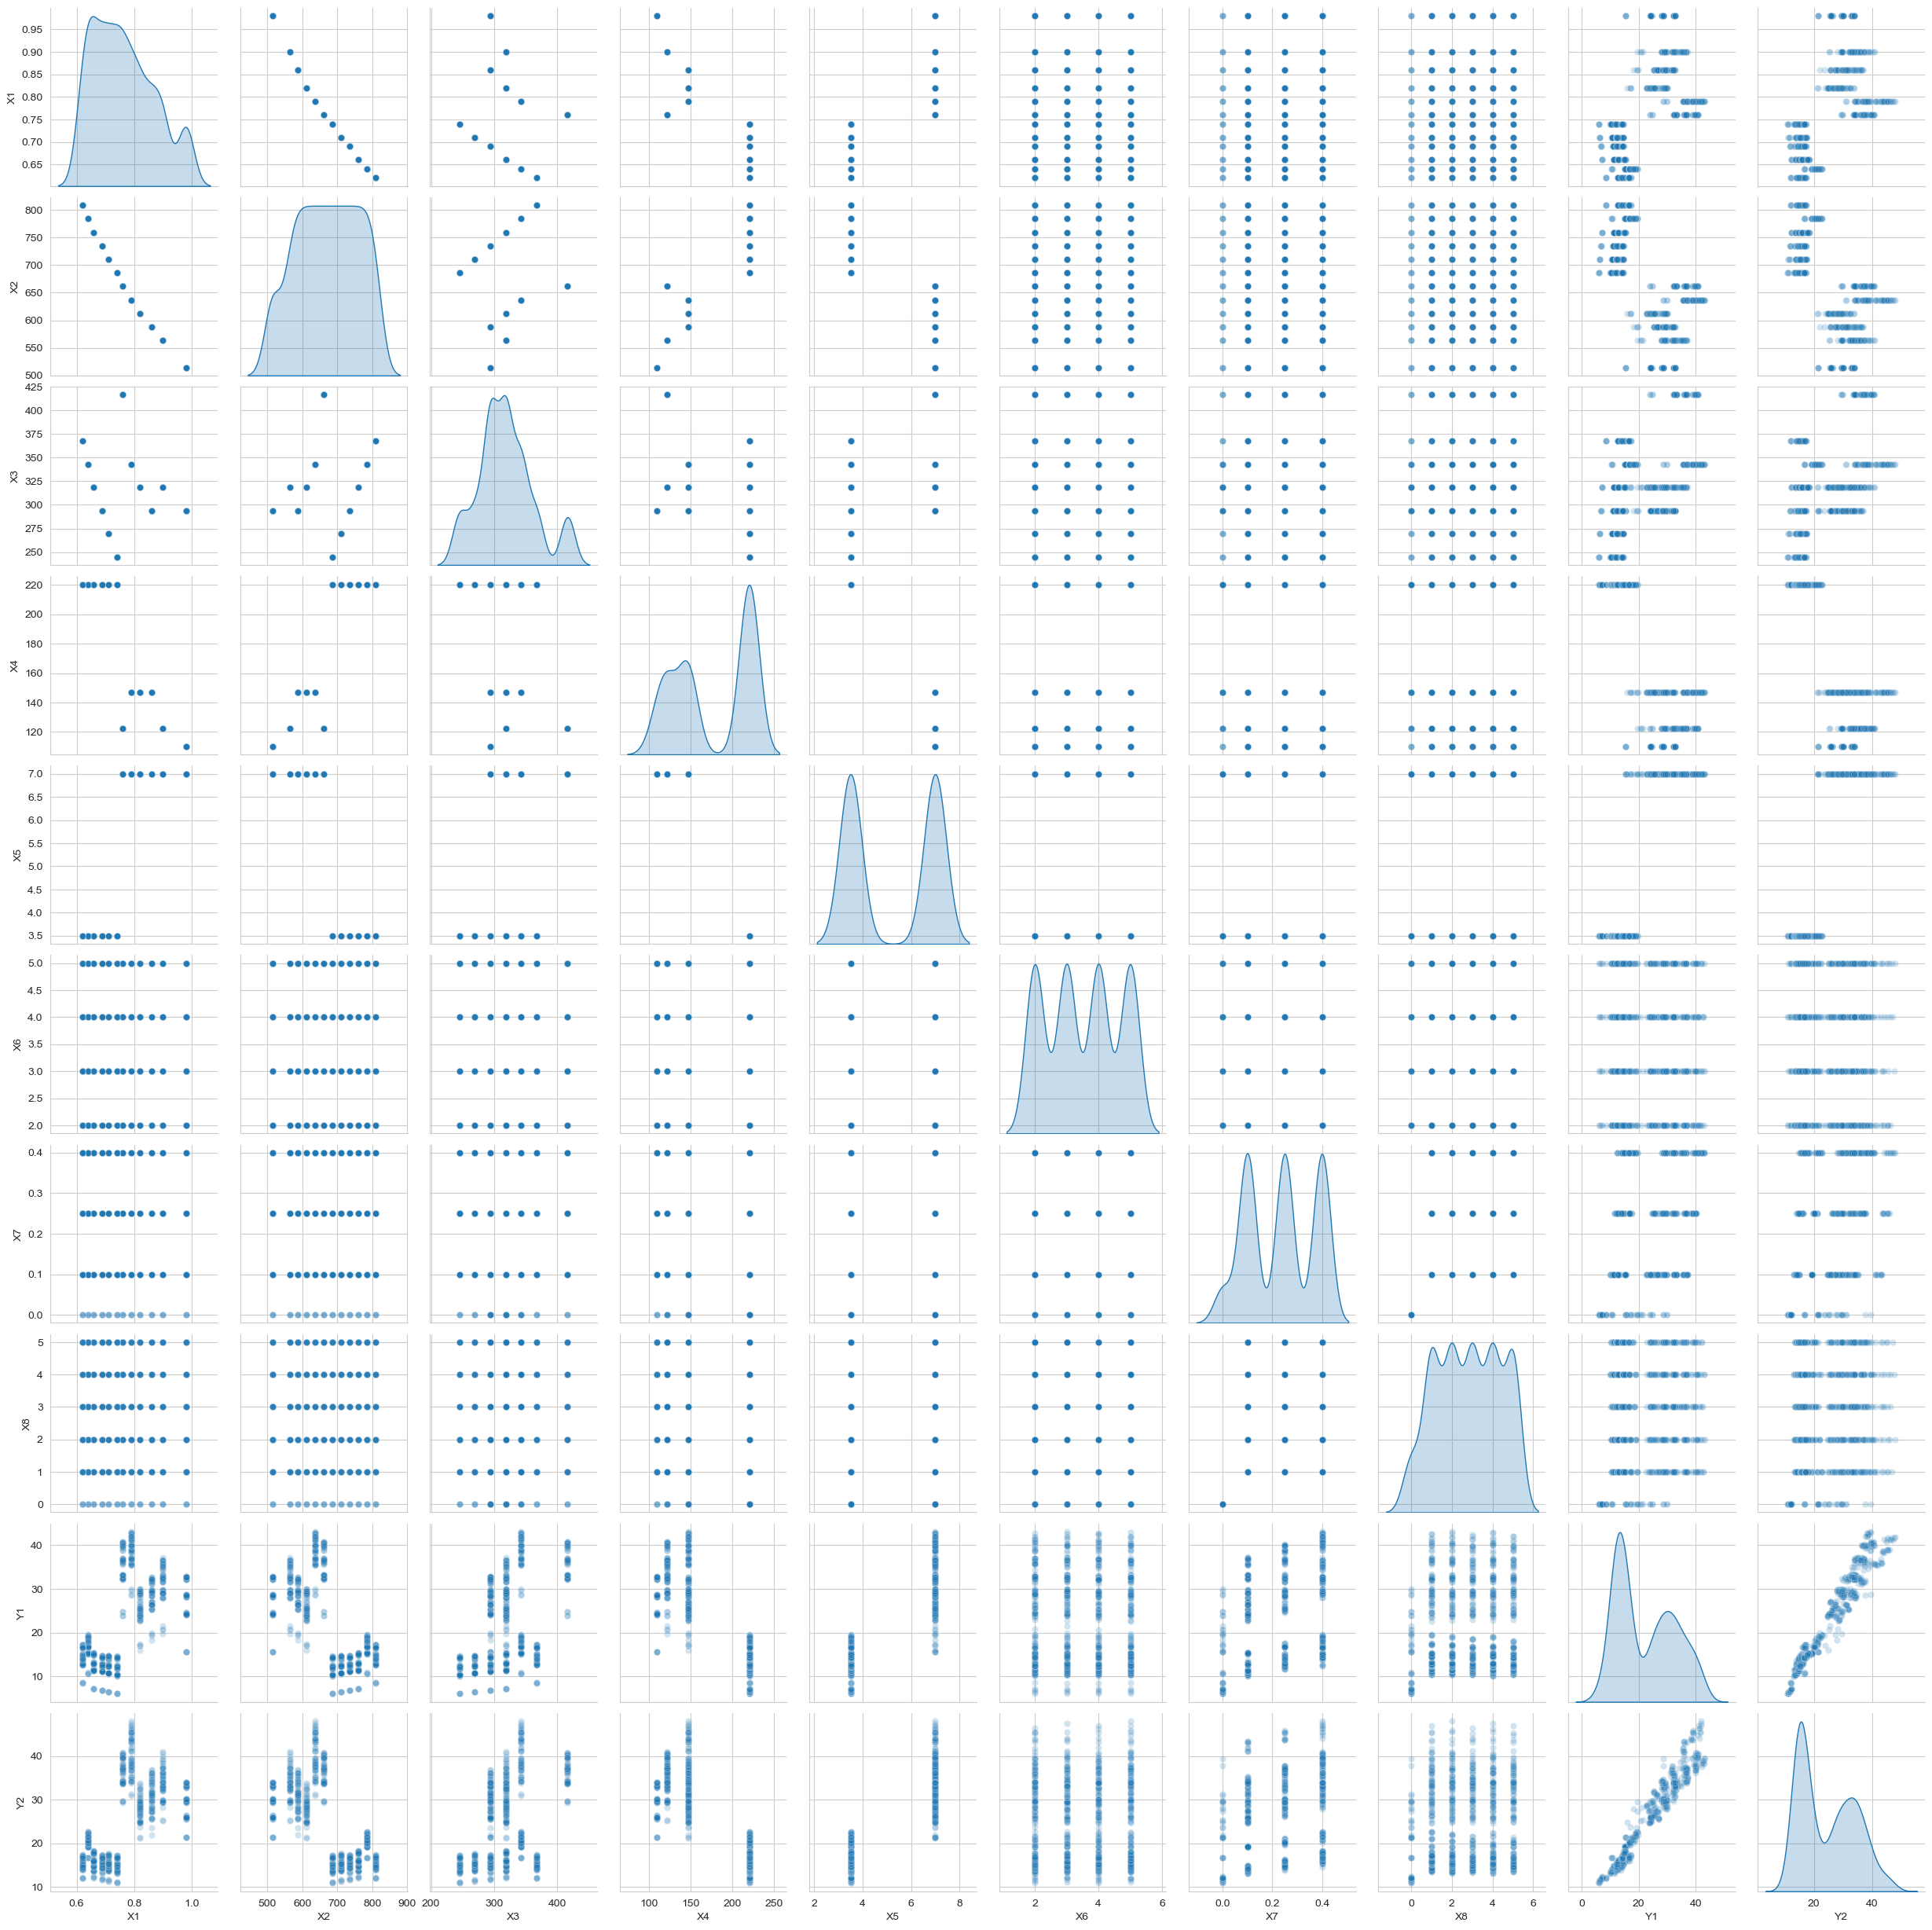

In [13]:
import seaborn as sns

sns.pairplot(ds,diag_kind='kde',plot_kws={'alpha': .2});

In [14]:
# shuffle data
data = ds.values[np.random.permutation(np.arange(len(ds.values)))]

in_dim, out_dim = data.shape[1] - 1, 1

X, y = data[:, :in_dim], data[:, in_dim:]

# normalize and center data
X_means, X_stds = X.mean(axis=0), X.std(axis=0)
y_means, y_stds = y.mean(axis=0), y.std(axis=0)
X = (X - X_means)/X_stds
y = (y - y_means)/y_stds

#### 5 Fold Cross Validation for Linear Regression

In [15]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf =KFold(n_splits=5, shuffle=True, random_state=42)
# We use negative mean squared error as score because sklearn expects a score, not a loss
score = cross_val_score(linear_model.LinearRegression(), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {-score}')

print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.04508511 0.03388558 0.04359116 0.04469006 0.04422692]
Avg MSE = 0.04


#### 5 Fold Cross Validation for Decision Tree

In [16]:
score = cross_val_score(tree.DecisionTreeRegressor(random_state= 42), X, y, cv=kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.04037644 0.0262939  0.02933478 0.0322292  0.03459132]
Avg MSE = 0.03


#### 5 Fold Cross Validation for Random Forest

In [17]:
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.01956803 0.01147781 0.01869329 0.02574194 0.01819917]
Avg MSE = 0.02


#### 5 Fold Cross for Hyper param optimization of Decision Tree

In [18]:
max_depth = [1,5,10,20,50,100]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeRegressor(max_depth= val, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For max depth: 1
Avg MSE = 0.19
For max depth: 5
Avg MSE = 0.03
For max depth: 10
Avg MSE = 0.03
For max depth: 20
Avg MSE = 0.03
For max depth: 50
Avg MSE = 0.03
For max depth: 100
Avg MSE = 0.03


#### 5 Fold Cross for Hyper param optimization of Random Forest

In [19]:
estimators = [10, 50, 100, 150, 200, 250, 300]

for count in estimators:
    score = cross_val_score(ensemble.RandomForestRegressor(n_estimators= count, random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")
    print(f'For estimators: {count}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For estimators: 10
Avg MSE = 0.02
For estimators: 50
Avg MSE = 0.02
For estimators: 100
Avg MSE = 0.02
For estimators: 150
Avg MSE = 0.02
For estimators: 200
Avg MSE = 0.02
For estimators: 250
Avg MSE = 0.02
For estimators: 300
Avg MSE = 0.02


#### NN Regressor

In [23]:
from torch import nn

class NNRegressor(nn.Module):
    def __init__(self, layers=[20,30,20], n_features=9, activation=nn.ReLU):
        super().__init__()
        self.layers = []
        self.activation_functions = []

        self.layers.append(nn.Linear(n_features, layers[0]))
        self.activation_functions.append(activation())
        self.add_module(f"layer{0}", self.layers[-1])
        self.add_module(f"act{0}", self.activation_functions[-1])

        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(self.layers[-1].out_features, layers[i]))
            self.activation_functions.append(activation())
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.activation_functions[-1])

        self.output = nn.Linear(self.layers[-1].out_features, 1)

    def forward(self, x):
        for layer, act in zip(self.layers, self.activation_functions):
            x=act(layer(x))

        x = self.output(x)
        return x

#### Grid search hyper param optimization for NN

In [24]:
from sklearn.model_selection import GridSearchCV
from torch import optim
from skorch import NeuralNetRegressor

param_grid = {
    'optimizer': [optim.Adam, optim.Adamax, optim.NAdam],
    'module__activation': [nn.Identity, nn.ReLU, nn.GELU, nn.Tanh, nn.Sigmoid],
    'batch_size': [10, 25, 50],
    'module__layers': [[10,20,10],[30,20,10],[30,30,30]],
    'lr': [0.0001, 0.001, 0.01],
}

grid = GridSearchCV(
    estimator = NeuralNetRegressor(module=NNRegressor),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 3,
    error_score = 'raise',
    return_train_score = True,
    verbose = 0,
    scoring = 'neg_mean_squared_error'
)

In [25]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

grid.fit(X_tensor, y_tensor)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1988        0.9876  0.1107
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1729        1.0222  0.0474
      2        1.1278        0.9336  0.0192
      2        1.0829        0.9430  0.0182
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.3735        1.0875  0.0588
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9907        0.9119  0.0510
      3        1.0665        0.8844  0.0295
      3        0.9991        0.8654  0.0187
      2        1.2898        1.0257  0.0228
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0810        1.0248  0.0439
      2        0.9120        0.8277  0.0322
      4        1.0092        0.8366  0.0279
      3        1.2155        0.9

GridSearchCV(cv=3, error_score='raise',
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.NNRegressor'>,
),
             n_jobs=-1,
             param_grid={'batch_size': [10, 25, 50],
                         'lr': [0.0001, 0.001, 0.01],
                         'module__activation': [<class 'torch.nn.modules.linear.Identity'>,
                                                <class 'torch.nn.modules.activation.ReLU'>,
                                                <class 'torch.nn.modules.activation.GELU'>,
                                                <class 'torch.nn.modules.activation.Tanh'>,
                                                <class 'torch.nn.modules.activation.Sigmoid'>],
                         'module__layers': [[10, 20, 10], [30, 20, 10],
                                            [30, 30, 30]],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.adamax.Adamax'>,
                                       <class 'torch.optim.nadam.NAdam'>]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
print("Best params:")
grid.best_params_

Best params:


{'batch_size': 25,
 'lr': 0.01,
 'module__activation': torch.nn.modules.activation.ReLU,
 'module__layers': [30, 30, 30],
 'optimizer': torch.optim.adam.Adam}

In [27]:
print(f'Best MSE = {"{:.2f}".format(-grid.best_score_)}')

Best MSE = 0.04


# Results
The best model is the Random Forest with at least 10 estimators. The avarage MSE for the model is 0.02